In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('//content/gdrive/My Drive/Colab Notebooks/')

In [0]:
#export
from exp.nb_09c import *

##PIL transforms

In [0]:
#export
make_rgb._order=0

In [0]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

In [0]:
def get_il(tfms): return ImageList.from_files(path, tfms=tfms)

In [0]:
il = get_il(tfms)

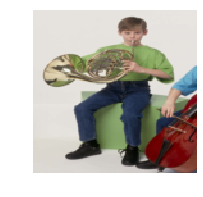

In [7]:
show_image(il[0])

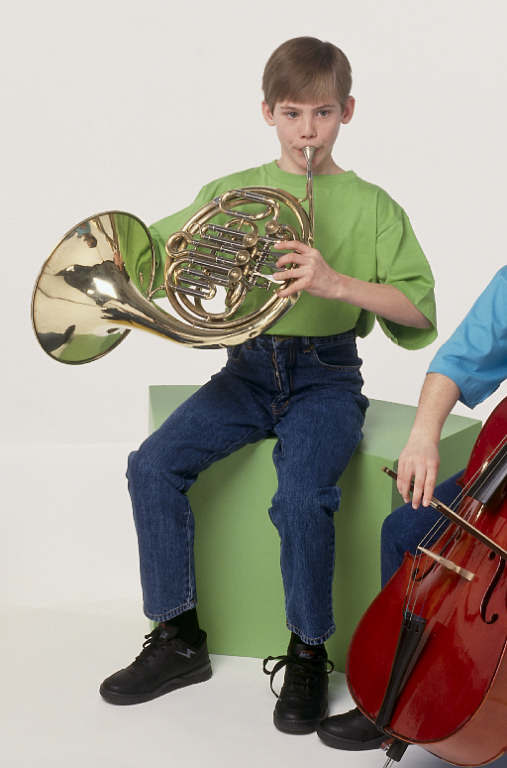

In [8]:
img = PIL.Image.open(il.items[0])
img

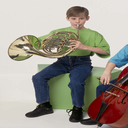

In [9]:
img.resize((128,128),resample=PIL.Image.ANTIALIAS)

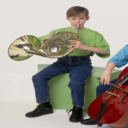

In [10]:
img.resize((128,128),resample=PIL.Image.BILINEAR)

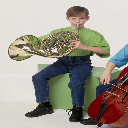

In [11]:
img.resize((128,128),resample=PIL.Image.NEAREST)

In [12]:
%timeit -n 10 img.resize((224,224), resample=PIL.Image.NEAREST)

10 loops, best of 3: 127 µs per loop


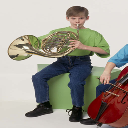

In [13]:
img.resize((256,256),resample=PIL.Image.BICUBIC).resize((128,128),resample=PIL.Image.NEAREST)

###flipping

In [0]:
#export
import random

In [0]:
def pil_random_flip(x):
  return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<0.5 else x

In [0]:
il1 = get_il(tfms)
il1.items = [il1.items[0]]*64
dl = DataLoader(il1,8)

In [0]:
x=next(iter(dl))

In [0]:
#export
def show_image(im, ax=None, figsize=(3,3)):
    if ax is None: _,ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    ax.imshow(im.permute(1,2,0))

def show_batch(x, c=4, r=None, figsize=None):
    n = len(x)
    if r is None: r = int(math.ceil(n/c))
    if figsize is None: figsize=(c*3,r*3)
    fig,axes = plt.subplots(r,c, figsize=figsize)
    for xi,ax in zip(x,axes.flat): show_image(xi, ax)  

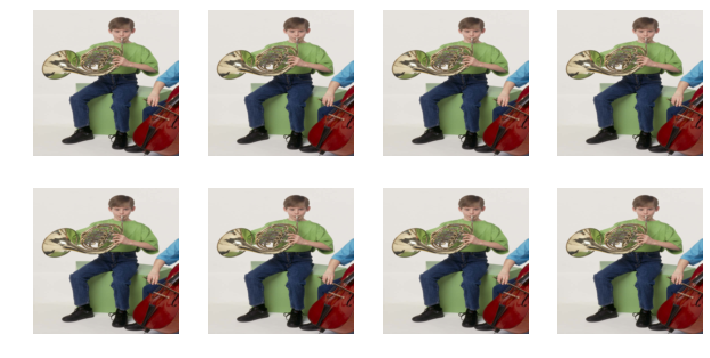

In [20]:
show_batch(x)

In [21]:
type(il)

exp.nb_08.ImageList

In [0]:
il1.tfms.append(pil_random_flip)

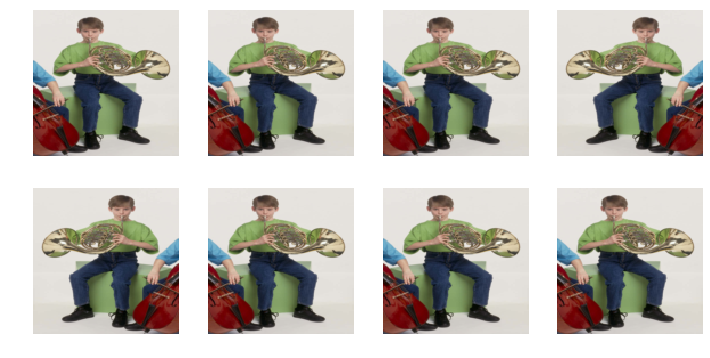

In [29]:
x=next(iter(dl))
show_batch(x)

In [0]:
#export
class PilTransform(Transform):
  _order=11
  
class PilRandomFlip(PilTransform):
  _order=11
  def __init__(self,p=0.5): self.p=p
  def __call__(self,x):
    return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<self.p else x

In [0]:
del(il1.tfms[-1])
il1.tfms.append(PilRandomFlip(0.8))

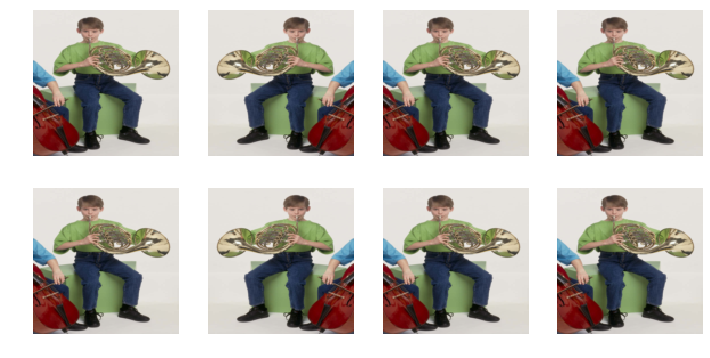

In [32]:
x = next(iter(dl))
show_batch(x)

In [33]:
PIL.Image.FLIP_LEFT_RIGHT,PIL.Image.ROTATE_270,PIL.Image.TRANSVERSE

(0, 4, 6)

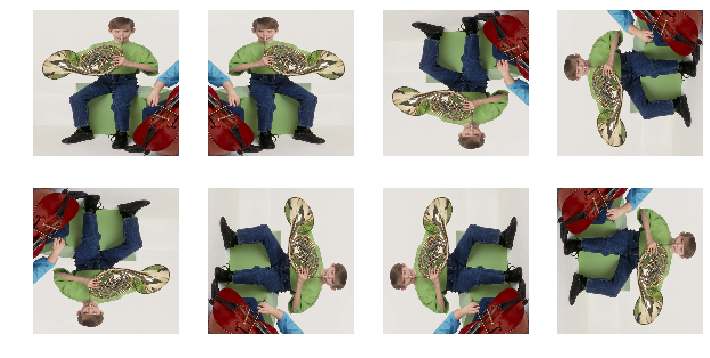

In [34]:
img = PIL.Image.open(il.items[0])
img = img.resize((128,128), resample=PIL.Image.NEAREST)
_, axs = plt.subplots(2, 4, figsize=(12, 6))
for i,ax in enumerate(axs.flatten()):
    if i==0: ax.imshow(img)
    else:    ax.imshow(img.transpose(i-1))
    ax.axis('off')

In [0]:
#export
class PilRandomDihedral(PilTransform):
  def __init__(self,p=0.75): self.p=p*7/8 #hack to get the 1/8 identity dihedral transform
  def __call__(self,x):
    if random.random()>self.p: return x
    return x.transpose(random.randint(0,6))

In [0]:
del(il1.tfms[-1])
il1.tfms.append(PilRandomDihedral())

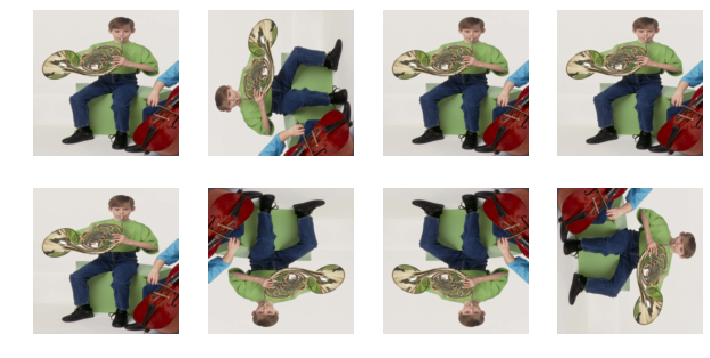

In [37]:
show_batch(next(iter(dl)))

###random cropin

In [59]:
img = PIL.Image.open(il.items[2])
img.size

(374, 500)

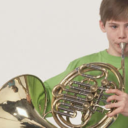

In [39]:
img.crop((60,60,320,320)).resize((128,128),resample=PIL.Image.BILINEAR)

In [0]:
cnr2 = (60,60,320,320)
resample = PIL.Image.BILINEAR

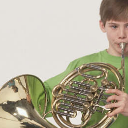

In [43]:
img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

In [44]:
%timeit -n 10 img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

10 loops, best of 3: 885 µs per loop


In [0]:
#export
from random import randint

def process_sz(sz):
    sz = listify(sz)
    return tuple(sz if len(sz)==2 else [sz[0],sz[0]])

def default_crop_size(w,h): return [w,w] if w < h else [h,h]

class GeneralCrop(PilTransform):
    def __init__(self, size, crop_size=None, resample=PIL.Image.BILINEAR): 
        self.resample,self.size = resample,process_sz(size)
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def default_crop_size(self, w,h): return default_crop_size(w,h)

    def __call__(self, x):
        csize = self.default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        return x.transform(self.size, PIL.Image.EXTENT, self.get_corners(*x.size, *csize), resample=self.resample)
    
    def get_corners(self, w, h): return (0,0,w,h)

class CenterCrop(GeneralCrop):
    def __init__(self, size, scale=1.14, resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale = scale
        
    def default_crop_size(self, w,h): return [w/self.scale,h/self.scale]
    
    def get_corners(self, w, h, wc, hc):
        return ((w-wc)//2, (h-hc)//2, (w-wc)//2+wc, (h-hc)//2+hc)

In [0]:
il1.tfms = [make_rgb, CenterCrop(128), to_byte_tensor, to_float_tensor]

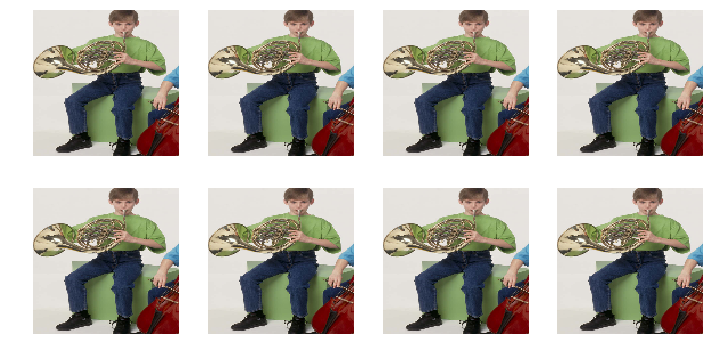

In [48]:
show_batch(next(iter(dl)))


### random resize crop

In [0]:
# export
class RandomResizedCrop(GeneralCrop):
    def __init__(self, size, scale=(0.08,1.0), ratio=(3./4., 4./3.), resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale,self.ratio = scale,ratio
    
    def get_corners(self, w, h, wc, hc):
        area = w*h
        #Tries 10 times to get a proper crop inside the image.
        for attempt in range(10):
            area = random.uniform(*self.scale) * area
            ratio = math.exp(random.uniform(math.log(self.ratio[0]), math.log(self.ratio[1])))
            new_w = int(round(math.sqrt(area * ratio)))
            new_h = int(round(math.sqrt(area / ratio)))
            if new_w <= w and new_h <= h:
                left = random.randint(0, w - new_w)
                top  = random.randint(0, h - new_h)
                return (left, top, left + new_w, top + new_h)
        
        # Fallback to central crop
        left,top = randint(0,w-self.crop_size[0]),randint(0,h-self.crop_size[1])
        return (left, top, left+self.crop_size[0], top+self.crop_size[1])
        # Fallback to central crop

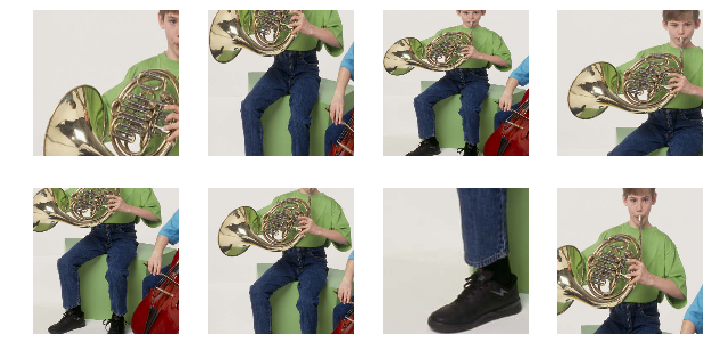

In [53]:
il1.tfms = [make_rgb, RandomResizedCrop(128), to_byte_tensor, to_float_tensor]
show_batch(next(iter(dl)))

###perspective warping

In [0]:
# export
from torch import FloatTensor,LongTensor

def find_coeffs(orig_pts, targ_pts):
    matrix = []
    #The equations we'll need to solve.
    for p1, p2 in zip(targ_pts, orig_pts):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = FloatTensor(matrix)
    B = FloatTensor(orig_pts).view(8, 1)
    #The 8 scalars we seek are solution of AX = B
    return list(torch.solve(B,A)[0][:,0])

In [0]:
# export
def warp(img, size, src_coords, resample=PIL.Image.BILINEAR):
    w,h = size
    targ_coords = ((0,0),(0,h),(w,h),(w,0))
    c = find_coeffs(src_coords,targ_coords)
    res = img.transform(size, PIL.Image.PERSPECTIVE, list(c), resample=resample)
    return res

In [0]:
targ = ((0,0),(0,128),(128,128),(128,0))
src  = ((90,60),(30,280),(310,280),(250,60))

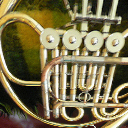

In [60]:
c = find_coeffs(src, targ)
img.transform((128,128), PIL.Image.PERSPECTIVE, list(c), resample=resample)

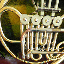

In [61]:
warp(img, (64,64), src, resample=PIL.Image.BICUBIC)

In [0]:
# export
def uniform(a,b): return a + (b-a) * random.random()

In [0]:
class PilTiltRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.NEAREST): 
        self.resample,self.size,self.magnitude = resample,process_sz(size),magnitude
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def __call__(self, x):
        csize = default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        up_t,lr_t = uniform(-self.magnitude, self.magnitude),uniform(-self.magnitude, self.magnitude)
        left,top = randint(0,x.size[0]-csize[0]),randint(0,x.size[1]-csize[1])
        src_corners = tensor([[-up_t, -lr_t], [up_t, 1+lr_t], [1-up_t, 1-lr_t], [1+up_t, lr_t]])
        src_corners = src_corners * tensor(csize).float() + tensor([left,top]).float()
        src_corners = tuple([(int(o[0].item()), int(o[1].item())) for o in src_corners])
        return warp(x, self.size, src_corners, resample=self.resample)

In [0]:
il1.tfms = [make_rgb, PilTiltRandomCrop(128, magnitude=0.1), to_byte_tensor, to_float_tensor]

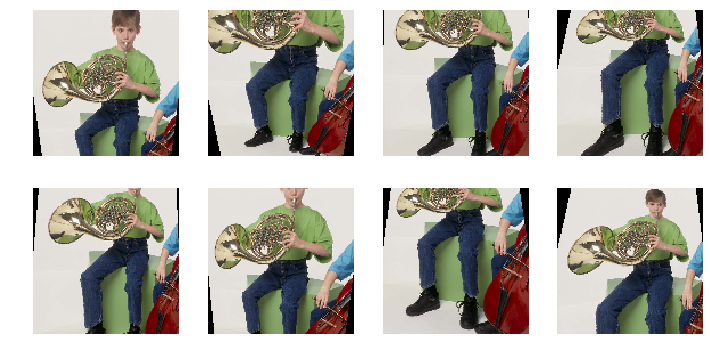

In [65]:
x = next(iter(dl))
show_batch(x)

### finish

In [66]:
[(o._order,o) for o in sorted(tfms, key=operator.attrgetter('_order'))]

[(0, <function exp.nb_08.make_rgb>),
 (10, <exp.nb_08.ResizeFixed at 0x7f8cfa8da860>),
 (11, <__main__.PilRandomDihedral at 0x7f8c8e6f4f60>),
 (20, <function exp.nb_08.to_byte_tensor>),
 (30, <function exp.nb_08.to_float_tensor>)]

In [0]:
#export
import numpy as np

def np_to_float(x): return torch.from_numpy(np.array(x, dtype=np.float32, copy=False)).permute(2,0,1).contiguous()/255.
np_to_float._order = 30

In [70]:
%timeit -n 10 to_float_tensor(to_byte_tensor(img))

10 loops, best of 3: 1.4 ms per loop


In [71]:
%timeit -n 10 np_to_float(img)

10 loops, best of 3: 1.71 ms per loop


####batch data augumentation

In [0]:
# https://render.githubusercontent.com/view/ipynb?commit=3b1fc475da12aa7a4526a5c28ad5d9d75c2c27e0&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6661737461692f636f757273652d76332f336231666334373564613132616137613435323661356332386164356439643735633263323765302f6e62732f646c322f31305f6175676d656e746174696f6e2e6970796e62&nwo=fastai%2Fcourse-v3&path=nbs%2Fdl2%2F10_augmentation.ipynb&repository_id=152646389&repository_type=Repository#Batch-data-augmentation